Data is filthy.

# Extraction, first look

In [22]:
library("dplyr")

choco <- read.csv("choco_wprice.csv", stringsAsFactors = FALSE)

summary(choco)

Warning message:
"package 'dplyr' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




   Company          Specific.Bean.Origin      REF        Review.Date  
 Length:1852        Length:1852          Min.   :   5   Min.   :2006  
 Class :character   Class :character     1st Qu.: 600   1st Qu.:2010  
 Mode  :character   Mode  :character     Median :1099   Median :2013  
                                         Mean   :1065   Mean   :2012  
                                         3rd Qu.:1546   3rd Qu.:2015  
                                         Max.   :2008   Max.   :2017  
                                                                      
 Cocoa.Percent   Company.Location       Rating       Bean.Type        
 Min.   : 42.0   Length:1852        Min.   :1.000   Length:1852       
 1st Qu.: 70.0   Class :character   1st Qu.:3.000   Class :character  
 Median : 70.0   Mode  :character   Median :3.250   Mode  :character  
 Mean   : 71.7                      Mean   :3.265                     
 3rd Qu.: 75.0                      3rd Qu.:3.500                     
 Max. 

# Transformation

 • Deleting missing values

In [3]:
# Let's see how many missing values per attribute we have.

missing_values_count <- sapply(
  choco, function(x) sum(x == "" | is.na(x))
) # That is, the sum of every blank or N/A value

print(missing_values_count)

             Company Specific.Bean.Origin                  REF 
                   0                    0                    0 
         Review.Date        Cocoa.Percent     Company.Location 
                   0                    0                    0 
              Rating            Bean.Type    Broad.Bean.Origin 
                 265                  938                   74 
           Bar.Price 
                 556 


In [4]:
# Now, let's see the proportion of these values.

# Rule of thumb, an attribute with > 50, maybe 60% missing data is a candidate for deletion in a static dataset

missing_values_proportion <- sapply(
  choco, function(x) sum(x == "" | is.na(x)) / nrow(choco)
)

print(missing_values_proportion)

             Company Specific.Bean.Origin                  REF 
           0.0000000            0.0000000            0.0000000 
         Review.Date        Cocoa.Percent     Company.Location 
           0.0000000            0.0000000            0.0000000 
              Rating            Bean.Type    Broad.Bean.Origin 
           0.1430886            0.5064795            0.0399568 
           Bar.Price 
           0.3002160 


In [5]:
# For the sake of practice, let's delete atts missing 50% or more of values

atts_to_delete <- which(missing_values_proportion >= 0.5)
choco <- choco[, -atts_to_delete]

 • Replacing missing values

In [11]:
# Let's see if there are any atts whose values can be estimated.

# We could replace with 0, replace with mean, or replace with median.

# We'll go with the mean for Bar.Price:

choco$Bar.Price[is.na(choco$Bar.Price)] <- mean(choco$Bar.Price, na.rm = TRUE)

head(choco)

,Company,Specific.Bean.Origin,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Broad.Bean.Origin,Bar.Price
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,A. Morin,Agua Grande,1876,2016,63,France,3.75,Sao Tome,2.535807
2,A. Morin,Kpime,1676,2015,70,France,NA,Togo,5.997822
3,A. Morin,Panama,1011,2013,70,France,NA,Panama,5.455234
4,A. Morin,Madagascar,1011,2013,70,France,3.00,Madagascar,7.014562
5,A. Morin,Brazil,1011,2013,70,France,3.25,Brazil,5.889096
6,A. Morin,Equateur,1011,2013,70,France,3.75,Ecuador,2.836863


 • Replacing missing values stratigraphically

In [34]:
sum(is.na(choco$Rating)) # Missing ratings

# We can estimate missing ratings according to median by company:

per_comp = aggregate(choco$Rating, by=list(choco$Company), na.rm=TRUE, median)
colnames(per_comp) = c("Company", "MRating")

# Replacing some values manually

choco$Rating[is.na(choco$Rating) & choco$Company == "Vicuna"] <- per_comp$Rating[per_comp$Company == "Vicuna"]
choco$Rating[is.na(choco$Rating) & choco$Company == "Zokoko"] <- per_comp$Rating[per_comp$Company == "Zokoko"]
choco$Rating[is.na(choco$Rating) & choco$Company == "Videri"] <- per_comp$Rating[per_comp$Company == "Videri"]


choco %>% filter(Company == "Zokoko") %>% select(Rating)


[1] 265

Rating
<dbl>
3.75
3.25
3.50
3.50
3.75


# Checking out outliers

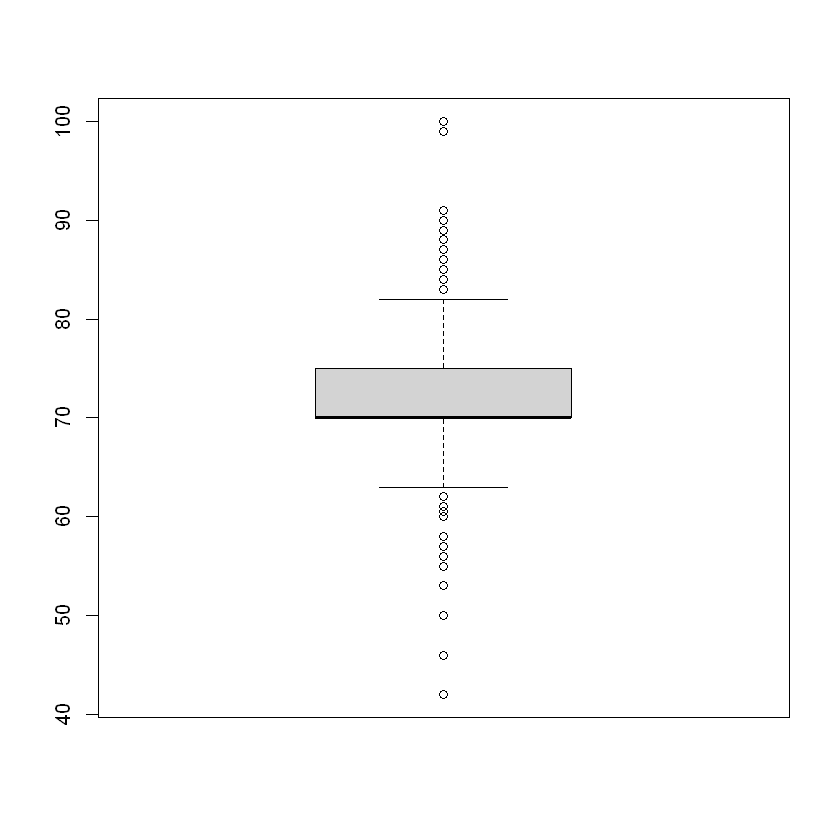

In [35]:
boxplot(choco$Cocoa.Percent)

# Boxplots show values more than three stdevs away from the median as outliers.

# Could these really be of extremely high/low quality or simply anomalies? Judgment call!